In [10]:
import logging

import numpy as np
import astropy.io.ascii as at
import matplotlib.pyplot as plt
%matplotlib inline

from astroML import time_series

from k2spin import lc
from k2spin import k2io
from k2spin import plot

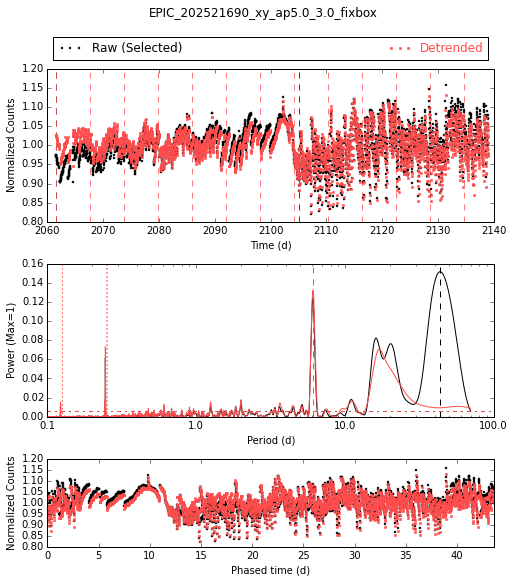

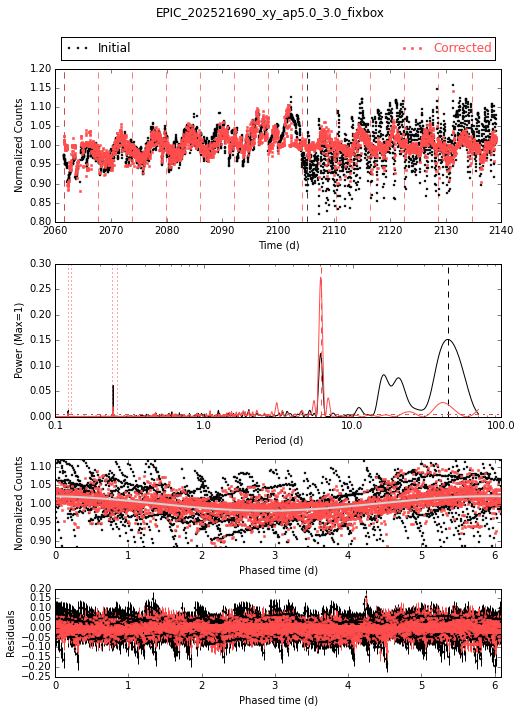

In [40]:
lc_dir = "/home/stephanie/code/python/k2spin/lcs/"
filename = "EPIC_202521690_xy_ap5.0_3.0_fixbox.dat"

lc_out = k2io.read_double_aperture(lc_dir+filename)
time, fluxes, unc_fluxes, x_pos, y_pos, qual_flux, apertures = lc_out
    
light_curve = lc.LightCurve(time, fluxes[1], unc_fluxes[1], x_pos, y_pos,
                                name=filename[:-4])
light_curve.choose_initial()
light_curve.correct_and_fit()


t = light_curve.time
y = light_curve.flux
dy = light_curve.unc_flux


In [34]:
C_EK, C_EK_err, bins = time_series.ACF_EK(t, y, y,
                                          bins=np.linspace(0,70,400)
                                          )
t_EK = 0.5 * (bins[1:] + bins[:-1])

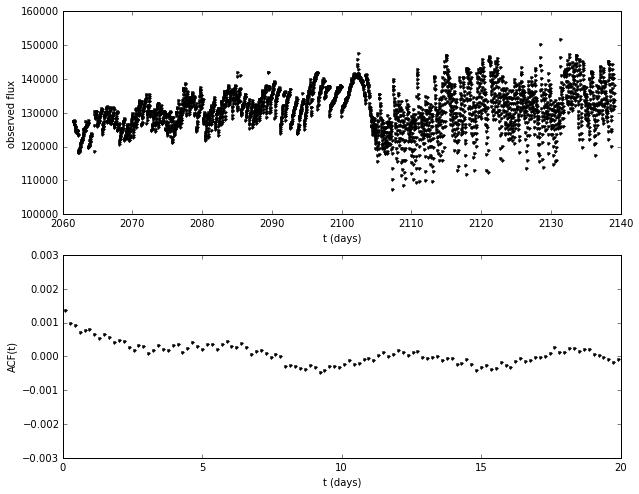

In [39]:
# Plot the results
fig = plt.figure(figsize=(10, 8))

# plot the input data
ax = fig.add_subplot(211)
#ax.errorbar(t, y, dy, fmt='.k', lw=1)
ax.plot(t, y,'k.', lw=1)
ax.set_xlabel('t (days)')
ax.set_ylabel('observed flux')

# plot the ACF
ax = fig.add_subplot(212)
#ax.errorbar(t_EK, C_EK, C_EK_err, fmt='.k', lw=1)
ax.plot(t_EK, C_EK, 'k.', lw=1)
ax.set_xlim(0, 20)
ax.set_ylim(-0.003, 0.003)

ax.set_xlabel('t (days)')
ax.set_ylabel('ACF(t)')


In [36]:
cadence = np.median(np.diff(t))
print cadence

0.0204317500002


In [43]:
t = light_curve.time
y = light_curve.corrected_flux
dy = light_curve.corrected_unc

In [44]:
C_EK, C_EK_err, bins = time_series.ACF_EK(t, y, y,
                                          bins=np.linspace(0,70,400)
                                          )
t_EK = 0.5 * (bins[1:] + bins[:-1])

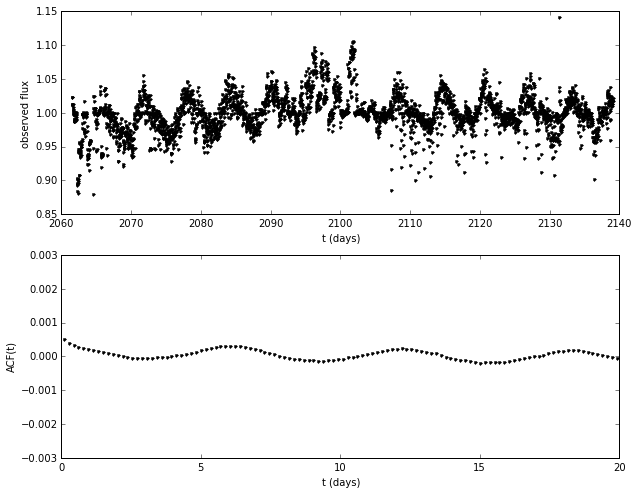

In [45]:
# Plot the results
fig = plt.figure(figsize=(10, 8))

# plot the input data
ax = fig.add_subplot(211)
#ax.errorbar(t, y, dy, fmt='.k', lw=1)
ax.plot(t, y,'k.', lw=1)
ax.set_xlabel('t (days)')
ax.set_ylabel('observed flux')

# plot the ACF
ax = fig.add_subplot(212)
#ax.errorbar(t_EK, C_EK, C_EK_err, fmt='.k', lw=1)
ax.plot(t_EK, C_EK, 'k.', lw=1)
ax.set_xlim(0, 20)
ax.set_ylim(-0.003, 0.003)

ax.set_xlabel('t (days)')
ax.set_ylabel('ACF(t)')